In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

In [2]:
scale_factor = {'x':123.36842467213701,
                'y':30.935225317219164,
                'cotA':6.528905408493022,
                'cotB':1.8827422609846889
               }

In [3]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

In [4]:
def rescale(df):

    for v in ['x','y','cotA','cotB']:
        if v in df.columns:
            df[v] = scale_factor[v]*df[v]
            df[v+'true'] = scale_factor[v]*df[v+'true']
        if 'sigma'+v in df.columns:
            df['sigma'+v] = scale_factor[v]*df['sigma'+v]

    return df

In [5]:
def inverse_cot(cota):
    a = np.array(np.arctan(1.0/cota))
    a[np.where(a<0)] = a[np.where(a<0)] + np.pi
    
    return a 

In [6]:
def get_pulls(df):
    for v in ['x','y','cotA','cotB']:        
        df['pull'+v] = (df[v] - df[v+'true'])/df['sigma'+v]

    return df

In [7]:
def get_residuals(df):
    for v in ['x','y','cotA','cotB']:
        if v in df.columns:
            df['residual'+v] = (df[v] - df[v+'true'])

    for v in ['cotA','cotB']:
        if v in df.columns:
            df[v[-1]] = inverse_cot(df[v])*180/np.pi
            df[v[-1]+'true'] = inverse_cot(df[v+'true'])*180/np.pi
            df['residual'+v[-1]] = (df[v[-1]] - df[v[-1]+'true'])

    return df

In [8]:
def sigmas_in_deg(df):

    for a in ['A','B']:
        df['upsigma'+a] = abs(inverse_cot(predictions[m][n]['cot'+a] + predictions[m][n]['sigmacot'+a])*180/np.pi - predictions[m][n][a])
        df['downsigma'+a] = abs(inverse_cot(predictions[m][n]['cot'+a] - predictions[m][n]['sigmacot'+a])*180/np.pi - predictions[m][n][a])             

    return df

In [9]:
def get_covariance(df):

    df['cov_xy'] = (scale_factor['x']*scale_factor['y'])*df['M11']*df['M21']
    df['cov_xcotA'] = (scale_factor['x']*scale_factor['cotA'])*df['M11']*df['M31']
    df['cov_xcotB'] = (scale_factor['x']*scale_factor['cotB'])*df['M11']*df['M41']
    df['cov_ycotA'] = (scale_factor['y']*scale_factor['cotA'])*(df['M21']*df['M31'] + df['M22']*df['M32'])
    df['cov_ycotB'] = (scale_factor['y']*scale_factor['cotB'])*(df['M41']*df['M21'] + df['M42']*df['M22'])
    df['cov_cotAcotB'] = (scale_factor['cotA']*scale_factor['cotB'])*(df['M41']*df['M31'] + df['M42']*df['M32'] + df['M33']*df['M43'])

    df['corr_xy'] = df['cov_xy']/(df['sigmax']*df['sigmay'])
    df['corr_xcotA'] = df['cov_xcotA']/(df['sigmax']*df['sigmacotA'])
    df['corr_xcotB'] = df['cov_xcotB']/(df['sigmax']*df['sigmacotB'])
    df['corr_ycotA'] = df['cov_ycotA']/(df['sigmay']*df['sigmacotA'])
    df['corr_ycotB'] = df['cov_ycotB']/(df['sigmay']*df['sigmacotA'])
    df['corr_cotAcotB'] = df['cov_cotAcotB']/(df['sigmacotA']*df['sigmacotB'])
    for i in range(0,4):
        for j in range(0,4):

            if i>j:
                continue
                
            df.drop(labels='M'+str(j+1)+str(i+1),axis=1,inplace=True)    

    return df

In [10]:
# From Sofi
def shortest_interval_68(data, center_type='mean'):
    """
    Compute the shortest interval that contains 68% of the data.
    """
    data = np.sort(data)
    n = len(data)
    ci_size = int(np.floor(0.68 * n))
    min_width = float("inf")
    min_i = 0

    for i in range(n - ci_size):
        width = data[i + ci_size] - data[i]
        if width < min_width:
            min_width = width
            min_i = i

    low = data[min_i]
    high = data[min_i + ci_size]

    if center_type == 'mean':
        center = np.mean(data)
    else:
        center = np.median(data)

    return {
        "center": center,
        "error_low": float(center - low),
        "error_high": float(high - center),
        "center_type": center_type
    }

In [11]:
path = "/eos/uscms/store/user/jennetd/smart-pixels/parquet/shuffled/dataset_2s_16x16_50x12P5_centeredIncidence_parquets/predictions/"

In [12]:
predictions = {}
residuals = {}
pulls = {}

In [13]:
cols_max = ['x','y','cotA','cotB','sigmax','sigmay','sigmacotA','sigmacotB','xtrue','ytrue','cotAtrue','cotBtrue','M11','M21','M22','M31','M32','M33','M41','M42','M43','M44']
cols = ['x','y','cotA','cotB','sigmax','sigmay','sigmacotA','sigmacotB','xtrue','ytrue','cotAtrue','cotBtrue']
cols_slim = ['x','y','cotB','xtrue','ytrue','cotBtrue']

In [14]:
models = os.listdir(path)
for m in models:
    predictions[m] = {}
    for n in os.listdir(path+m):
        predictions[m][n] = pd.DataFrame()

        print(m,n)
        
        file = path+m+"/"+n+"/predictions.parquet"
        if os.path.exists(file):

            if "max" in m:
                predictions[m][n] = pd.read_parquet(path+m+"/"+n+"/predictions.parquet",columns=cols_max)
                predictions[m][n] = get_covariance(predictions[m][n])
                predictions[m][n] = get_pulls(predictions[m][n])
                predictions[m][n] = get_residuals(rescale(predictions[m][n]))        
                predictions[m][n] = sigmas_in_deg(predictions[m][n])
                
            elif "full" in m:
                predictions[m][n] = pd.read_parquet(path+m+"/"+n+"/predictions.parquet",columns=cols)
                predictions[m][n] = get_pulls(predictions[m][n])
                predictions[m][n] = get_residuals(rescale(predictions[m][n]))
                predictions[m][n] = sigmas_in_deg(predictions[m][n])
            else:
                predictions[m][n] = pd.read_parquet(path+m+"/"+n+"/predictions.parquet",columns=cols_slim)
                predictions[m][n] = get_residuals(rescale(predictions[m][n]))

            predictions[m][n]['xtrue'] = predictions[m][n]['xtrue'] - 50./2
            predictions[m][n]['ytrue'] = predictions[m][n]['ytrue'] - 12.5/2
            predictions[m][n]['x'] = predictions[m][n]['x'] - 50./2
            predictions[m][n]['y'] = predictions[m][n]['y'] - 12.5/2

            print(len(predictions[m][n]))
            

full_1dconv 1-noquant_20t
full_1dconv 2-noquant_2t
full_2dconv 1-noquant_20t
1389260
full_2dconv 2-noquant_2t
1389392
full_2dconv 3-input_dig_2t
full_2dconv 4-quantized
full_mlp 1-noquant_20t
1389260
full_mlp 2-noquant_2t
1389392
full_mlp 3-input_dig_2t
full_mlp 4-quantized
max_2dconv 1-noquant_20t
1389260
max_2dconv 2-noquant_2t
1388821
slim_1dconv 1-noquant_20t
slim_1dconv 2-noquant_2t
slim_2dconv 1-noquant_20t
slim_2dconv 2-noquant_2t
slim_mlp 1-noquant_20t
1388122
slim_mlp 2-noquant_2t
1389260


full_2dconv [1.09810236e+05 1.95198054e-02 1.01467480e+00]
(array([   129.,    137.,    196.,    259.,    378.,    512.,    722.,
         1048.,   1459.,   2237.,   3177.,   4707.,   7105.,  10292.,
        15032.,  21236.,  29068.,  39183.,  50838.,  63216.,  77683.,
        89767., 100219., 107898., 110293., 109159., 103417.,  93263.,
        80047.,  66235.,  53316.,  40637.,  30361.,  22237.,  16153.,
        11553.,   7823.,   5527.,   3708.,   2636.,   1791.,   1218.,
          817.,    554.,    403.,    270.,    213.,    150.,    111.]), array([-5.        , -4.79591837, -4.59183673, -4.3877551 , -4.18367347,
       -3.97959184, -3.7755102 , -3.57142857, -3.36734694, -3.16326531,
       -2.95918367, -2.75510204, -2.55102041, -2.34693878, -2.14285714,
       -1.93877551, -1.73469388, -1.53061224, -1.32653061, -1.12244898,
       -0.91836735, -0.71428571, -0.51020408, -0.30612245, -0.10204082,
        0.10204082,  0.30612245,  0.51020408,  0.71428571,  0.91836735,
        1.122448

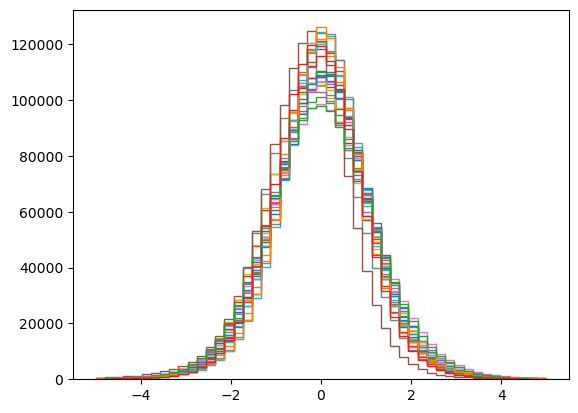

In [15]:
for m in predictions.keys():
    residuals[m] = {}
    if "slim" not in m:
        pulls[m] = {}
        
    for n in predictions[m].keys():

        if len(predictions[m][n].columns) == 0:
            continue

        residuals[m][n] = {}

        if "slim" not in m:

            pulls[m][n] = {}
            
            for v in ['x','y','cotA','cotB']:

                # Notes for pulls 
                h = plt.hist(predictions[m][n]['pull'+v],bins=np.linspace(-5,5,50),histtype='step')
               
                pars, cov = scipy.optimize.curve_fit(gauss,h[1][:-1] + 0.1,h[0])

                if v == 'x':
                    print(m,pars)
                    print(h)
                # Mean
                pulls[m][n]['mean_'+v] = pars[1] #float(np.mean(predictions[m][n]['pull'+v]))
                # Std
                pulls[m][n]['std_'+v] = abs(pars[2]) #float(np.std(predictions[m][n]['pull'+v]))

            # Residuals for cotA 
            residuals[m][n]['mean_cotA'] = float(np.mean(predictions[m][n]['residualcotA']))
            residuals[m][n]['std_cotA'] = float(np.std(predictions[m][n]['residualcotA']))
            interval68_cotA = shortest_interval_68(predictions[m][n]['residualcotA'], center_type='mean')
            residuals[m][n]['up68_cotA'] = interval68_cotA['error_high']
            residuals[m][n]['down68_cotA'] = interval68_cotA['error_low']

            # residuals for A
            residuals[m][n]['mean_A'] = float(np.mean(predictions[m][n]['residualA']))
            residuals[m][n]['std_A'] = float(np.std(predictions[m][n]['residualA']))
            interval68_A = shortest_interval_68(predictions[m][n]['residualA'], center_type='mean')
            residuals[m][n]['up68_A'] = interval68_A['error_high']
            residuals[m][n]['down68_A'] = interval68_A['error_low']

            # Mean predicted uncertainty 
            residuals[m][n]['mean_upsigmax'] = float(np.mean(predictions[m][n]['sigmax']))
            residuals[m][n]['mean_downsigmax'] = float(np.mean(predictions[m][n]['sigmax']))
            residuals[m][n]['mean_upsigmay'] = float(np.mean(predictions[m][n]['sigmay']))
            residuals[m][n]['mean_downsigmay'] = float(np.mean(predictions[m][n]['sigmay']))
            residuals[m][n]['mean_upsigmacotA'] = float(np.mean(predictions[m][n]['sigmacotA']))
            residuals[m][n]['mean_downsigmacotA'] = float(np.mean(predictions[m][n]['sigmacotA']))
            residuals[m][n]['mean_upsigmaA'] = float(np.mean(abs(inverse_cot(predictions[m][n]['cotA'] + predictions[m][n]['sigmacotA'])*180/np.pi - predictions[m][n]['A'])))
            residuals[m][n]['mean_downsigmaA'] = float(np.mean(abs(inverse_cot(predictions[m][n]['cotA'] - predictions[m][n]['sigmacotA'])*180/np.pi - predictions[m][n]['A'])))            
            residuals[m][n]['mean_upsigmacotB'] = float(np.mean(predictions[m][n]['sigmacotB']))
            residuals[m][n]['mean_downsigmacotB'] = float(np.mean(predictions[m][n]['sigmacotB']))
            residuals[m][n]['mean_upsigmaB'] = float(np.mean(abs(inverse_cot(predictions[m][n]['cotB'] + predictions[m][n]['sigmacotB'])*180/np.pi - predictions[m][n]['B'])))
            residuals[m][n]['mean_downsigmaB'] = float(np.mean(abs(inverse_cot(predictions[m][n]['cotB'] - predictions[m][n]['sigmacotB'])*180/np.pi - predictions[m][n]['B'])))

        # Residuals for x and y (microns)
        for v in ['x','y']:
            # Mean
            residuals[m][n]['mean_'+v] = float(np.mean(predictions[m][n]['residual'+v]))
            # Std -- replace with smallest window containing 68%
            residuals[m][n]['std_'+v] = float(np.std(predictions[m][n]['residual'+v]))

            interval68 = shortest_interval_68(predictions[m][n]['residual'+v], center_type='mean')
            residuals[m][n]['up68_'+v] = interval68['error_high']
            residuals[m][n]['down68_'+v] = interval68['error_low']

        # Residuals for cotB
        residuals[m][n]['mean_cotB'] = float(np.mean(predictions[m][n]['residualcotB']))
        residuals[m][n]['std_cotB'] = float(np.std(predictions[m][n]['residualcotB']))
        interval68_cotB = shortest_interval_68(predictions[m][n]['residualcotB'], center_type='mean')
        residuals[m][n]['up68_cotB'] = interval68_cotB['error_high']
        residuals[m][n]['down68_cotB'] = interval68_cotB['error_low']

        # Residuals for B
        residuals[m][n]['mean_B'] = float(np.mean(predictions[m][n]['residualB']))
        residuals[m][n]['std_B'] = float(np.std(predictions[m][n]['residualB']))
        interval68_B = shortest_interval_68(predictions[m][n]['residualB'], center_type='mean')
        residuals[m][n]['up68_B'] = interval68_B['error_high']
        residuals[m][n]['down68_B'] = interval68_B['error_low']
    

In [16]:
with open('dataset2s/pulls.json', 'w') as fp:
    json.dump(pulls, fp)

with open('dataset2s/residuals.json', 'w') as fp:
    json.dump(residuals, fp)

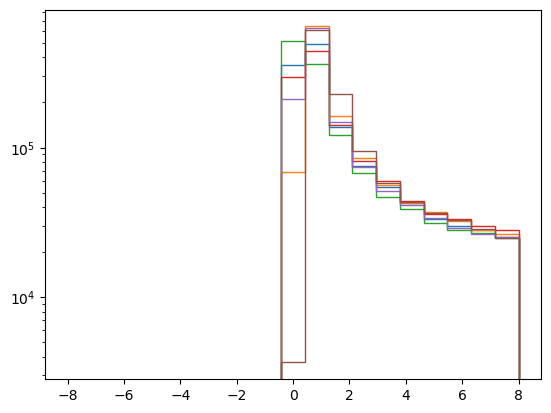

In [17]:
for m in predictions.keys():
    for n in predictions[m].keys():

        #if len(residuals[m][n].keys()) == 0:
        #    continue
        if 'cotA' in predictions[m][n].keys():
            plt.hist(predictions[m][n]['upsigmaA'],histtype='step',bins=np.linspace(-8,8,20))
            plt.yscale('log')

In [18]:
predictions['max_2dconv']['1-noquant_20t'].to_parquet('dataset2s/max_2dconv_noquant_20t.parquet')
predictions['max_2dconv']['2-noquant_2t'].to_parquet('dataset2s/max_2dconv_noquant_2t.parquet')

In [19]:
predictions['full_2dconv']['2-noquant_2t'].to_parquet('dataset2s/full_2dconv_noquant_2t.parquet')

In [20]:
predictions['full_1dconv']['2-noquant_2t'].to_parquet('dataset2s/full_1dconv_noquant_2t.parquet')

In [21]:
predictions['full_mlp']['2-noquant_2t'].to_parquet('dataset2s/full_mlp_noquant_2t.parquet')

In [22]:
predictions['slim_2dconv']['2-noquant_2t'].to_parquet('dataset2s/slim_2dconv_noquant_2t.parquet')

In [23]:
predictions['slim_1dconv']['2-noquant_2t'].to_parquet('dataset2s/slim_1dconv_noquant_2t.parquet')

In [24]:
predictions['slim_mlp']['2-noquant_2t'].to_parquet('dataset2s/slim_mlp_noquant_2t.parquet')